In [69]:
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

import os
import pathlib
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset
from typing import Tuple, Dict, List


In [2]:
# always check your version
print(torch.__version__)

1.13.1+cu116


## 1 Function implementations



### 1.1 Dataset class 

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [70]:
# TO COMPLETE
from google.colab import drive
drive.mount('/content/drive')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [4]:
pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
input_folder = '/content/drive/MyDrive/DEEP LEARNING /train_set/train_set'
splitfolders.ratio(input_folder, output='/content/drive/MyDrive/DEEP LEARNING /Train', seed=42, ratio=(.8,.2), group_prefix=None)

In [71]:
train = '/content/drive/MyDrive/DEEP LEARNING /Train/train'
test_val = '/content/drive/MyDrive/DEEP LEARNING /Train/val'
testing_set = "/content/drive/MyDrive/DEEP LEARNING /test_set/test_set"

input_folder = '/content/drive/MyDrive/DEEP LEARNING /train_set/train_set'

In [72]:
def names(directory):
  # 1. Get the class names by scanning the target directory
    class_names = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not class_names:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
    return class_names,class_to_idx

In [73]:

class imagefolder(Dataset):
  def __init__(self, directory,transforms=None):


    self.paths = list(pathlib.Path(directory).glob("*/*.JPEG"))
    self.transforms = transforms

    self.classes , self.class_to_idx = names(directory)
  
  def __len__(self):
    return len(self.paths)
  
  def __getitem__(self, index):
    image_path = self.paths[index]
    img = Image.open(image_path).convert("RGB")
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    img = self.transforms(img)
    return img,class_idx

In [74]:
transform = transforms.ToTensor()

In [75]:
train_set = imagefolder(train,transform)
test_val_set = imagefolder(test_val,transform)
#test_data = imagefolder(testing_set, val_transform)

In [76]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_val_loader = torch.utils.data.DataLoader(
    test_val_set,
    batch_size=32, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    testing_set,
    batch_size=1, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

### 1.2 Define a MLP model class 

In [132]:
# TO COMPLETE
# define a MLP Model class

#New Model
# Create a model with non-linear and linear layers
class modelv1(nn.Module):
    def __init__(self, input: int, output: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=output),

        )
    
    def forward(self, x):
        return self.layer_stack(x)
        
model_2 =  modelv1(3*64*64,30)
model_2.to(device)

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.001)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### 1.3 Define a CNN model class 

In [169]:
## Create a convolutional neural network 
class CNNModel(nn.Module):
   
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape,
                      128,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=2),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            #nn.Dropout(p=0.5),

            nn.Conv2d(128,
                      256,
                      kernel_size=3,
                      stride=1,
                      padding=2),
            nn.BatchNorm2d(256),         
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # default stride value is same as kernel_size
            #nn.Dropout(p=0.5) 

            nn.Conv2d(256,
                      512,
                      kernel_size=3,
                      stride=1,
                      padding=2),
            nn.BatchNorm2d(512),         
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5,
                         stride=2)   

            
            
                     

        )
       
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=32768, 
                      out_features=output_shape)
        )
    
    def forward(self, x):
       # x = self.block_1(x)
        # print(x.shape)
       # x = self.block_2(x)
        # print(x.shape)
       # x = self.classifier(x)
        # print(x.shape)
        return self.classifier(self.block_1(x))

torch.manual_seed(42)
model_3 = CNNModel(input_shape=3,
    output_shape=30).to(device)
model_3.to(device)

#loss func
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), 
                             lr=0.001)

## 2 Model training

### Train both MLP and CNN models

In [170]:
# compputer visionn train test function
def train_step(model: torch.nn.Module,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn):
            #  device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for batch, (X, y) in enumerate(data_loader):
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
              y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}\n")
        return test_loss, test_acc
       

In [159]:
import tqdm
results={"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "Epoch":[],
    }
    
epochs =20
    # 3. Loop through training and testing steps for a number of epochs
for epoch in range(epochs):
  train_loss, train_acc = train_step(model=model_2,
                                           data_loader=train_loader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn= accuracy_fn)
  test_loss, test_acc = test_step(model=model_2,
            data_loader=test_val_loader,
            loss_fn=loss_fn,
            accuracy_fn = accuracy_fn)
        
     
        # 5. Update results dictionary
  results["train_loss"].append(train_loss)
  results["train_acc"].append(train_acc)
  results["test_loss"].append(test_loss)
  results["test_acc"].append(test_acc)
  results["Epoch"].append(epoch)

Train loss: 3.21397 | Train accuracy: 12.87
Test loss: 3.21126 | Test accuracy: 10.85

Train loss: 3.18764 | Train accuracy: 13.17
Test loss: 3.18599 | Test accuracy: 11.76

Train loss: 3.16241 | Train accuracy: 13.49
Test loss: 3.16467 | Test accuracy: 11.95

Train loss: 3.14004 | Train accuracy: 13.57
Test loss: 3.14457 | Test accuracy: 12.90

Train loss: 3.11991 | Train accuracy: 13.78
Test loss: 3.12519 | Test accuracy: 13.27

Train loss: 3.10114 | Train accuracy: 14.19
Test loss: 3.11075 | Test accuracy: 13.93

Train loss: 3.08482 | Train accuracy: 14.78
Test loss: 3.09508 | Test accuracy: 13.82

Train loss: 3.06795 | Train accuracy: 15.16
Test loss: 3.08193 | Test accuracy: 13.38

Train loss: 3.05409 | Train accuracy: 15.12
Test loss: 3.06719 | Test accuracy: 14.34

Train loss: 3.04105 | Train accuracy: 15.48
Test loss: 3.05507 | Test accuracy: 14.49

Train loss: 3.02687 | Train accuracy: 15.97
Test loss: 3.04218 | Test accuracy: 14.19

Train loss: 3.01393 | Train accuracy: 16.33

In [166]:
li={"train_loss": [],
      "test_loss": [],  
    }
for i in results["train_loss"]:
  li["train_loss"].append(i.cpu().detach())
 

for i in results["test_loss"]:
  li["test_loss"].append(i.cpu())


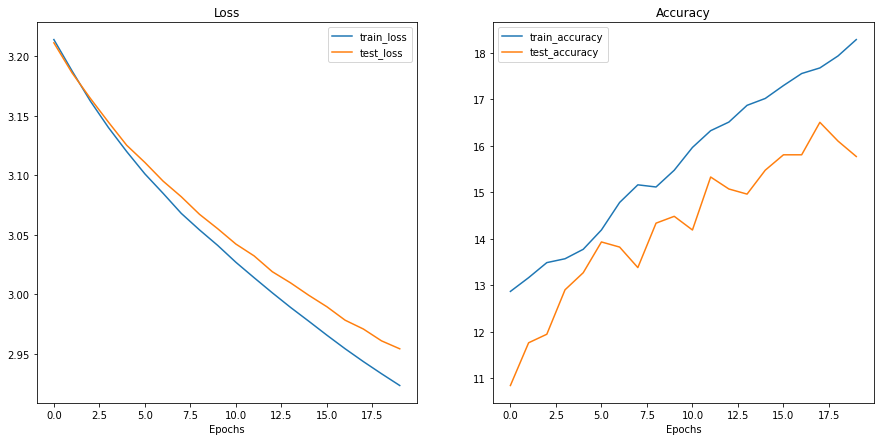

In [167]:
import numpy as np
plt.figure(figsize=(15, 7))

    # Plot loss
plt.subplot(1, 2, 1)
plt.plot(results["Epoch"],li["train_loss"], label='train_loss')
plt.plot(results["Epoch"], li["test_loss"], label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

    # Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(results["Epoch"], results["train_acc"], label='train_accuracy')
plt.plot(results["Epoch"], results["test_acc"], label='test_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [ ]:
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
#TO COMPLETE --> Running you MLP model class
# Train and test model 
epochs = 100
for epoch in (range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_val_loader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

In [173]:
#TO COMPLETE --> Running you CNN model class
# Train and test model 
epochs = 50
for epoch in (range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model_3, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_val_loader,
        model=model_3,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

Epoch: 0
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train loss: 1.20134 | Train accuracy: 65.29


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError:     can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test loss: 1.98083 | Test accuracy: 45.66

Epoch: 1
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train loss: 1.12074 | Train accuracy: 67.17


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test loss: 1.89593 | Test accuracy: 47.32

Epoch: 2
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train loss: 1.03010 | Train accuracy: 69.95


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
:     self._shutdown_workers()
can only test a child process
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test loss: 1.81495 | Test accuracy: 49.07

Epoch: 3
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers(): 
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():can only test a child process
  File "/usr/lib/python

Train loss: 0.95881 | Train accuracy: 72.24


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

AssertionError    : self._shutdown_workers()
can only test a child process  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/pytho

Test loss: 1.92751 | Test accuracy: 47.28

Epoch: 4
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train loss: 0.87510 | Train accuracy: 74.34


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test loss: 1.89661 | Test accuracy: 49.14

Epoch: 5
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
      File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train loss: 0.80189 | Train accuracy: 76.79


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test loss: 2.29606 | Test accuracy: 40.86

Epoch: 6
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train loss: 0.73021 | Train accuracy: 78.97


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test loss: 1.93484 | Test accuracy: 48.70

Epoch: 7
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in 

Train loss: 0.66307 | Train accuracy: 81.17


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test loss: 2.02013 | Test accuracy: 47.10

Epoch: 8
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train loss: 0.58308 | Train accuracy: 83.83


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test loss: 2.05590 | Test accuracy: 48.09

Epoch: 9
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train loss: 0.51683 | Train accuracy: 85.60


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test loss: 2.18439 | Test accuracy: 46.88

Epoch: 10
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train loss: 0.46341 | Train accuracy: 87.58


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test loss: 2.25207 | Test accuracy: 45.27

Epoch: 11
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train loss: 0.38650 | Train accuracy: 89.93


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
AssertionError    : self._shutdown_workers()can only test a child process

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test loss: 2.08337 | Test accuracy: 48.66

Epoch: 12
---------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffba0368280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train loss: 0.34269 | Train accuracy: 91.39
Test loss: 2.30381 | Test accuracy: 46.75

Epoch: 13
---------
Train loss: 0.29454 | Train accuracy: 93.40
Test loss: 2.35317 | Test accuracy: 46.65

Epoch: 14
---------
Train loss: 0.24923 | Train accuracy: 94.76
Test loss: 2.00289 | Test accuracy: 52.61

Epoch: 15
---------
Train loss: 0.21474 | Train accuracy: 95.86
Test loss: 2.40258 | Test accuracy: 47.06

Epoch: 16
---------
Train loss: 0.17696 | Train accuracy: 96.88
Test loss: 2.17619 | Test accuracy: 50.48

Epoch: 17
---------
Train loss: 0.13087 | Train accuracy: 98.01
Test loss: 2.64927 | Test accuracy: 48.68

Epoch: 18
---------
Train loss: 0.11366 | Train accuracy: 98.35
Test loss: 2.68964 | Test accuracy: 45.87

Epoch: 19
---------
Train loss: 0.10381 | Train accuracy: 98.65
Test loss: 2.20140 | Test accuracy: 52.65

Epoch: 20
---------
Train loss: 0.06718 | Train accuracy: 99.49
Test loss: 2.24189 | Test accuracy: 51.73

Epoch: 21
---------
Train loss: 0.05289 | Train accuracy:

In [174]:
import tqdm
results={"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "Epoch":[],
    }
    
epochs =20
    # 3. Loop through training and testing steps for a number of epochs
for epoch in range(epochs):
  train_loss, train_acc = train_step(model=model_3,
                                           data_loader=train_loader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn= accuracy_fn)
  test_loss, test_acc = test_step(model=model_3,
            data_loader=test_val_loader,
            loss_fn=loss_fn,
            accuracy_fn = accuracy_fn)
        
     
        # 5. Update results dictionary
  results["train_loss"].append(train_loss)
  results["train_acc"].append(train_acc)
  results["test_loss"].append(test_loss)
  results["test_acc"].append(test_acc)
  results["Epoch"].append(epoch)

Train loss: 0.00543 | Train accuracy: 100.00
Test loss: 2.70814 | Test accuracy: 52.90

Train loss: 0.00523 | Train accuracy: 100.00
Test loss: 2.72499 | Test accuracy: 52.76

Train loss: 0.00505 | Train accuracy: 100.00
Test loss: 2.73701 | Test accuracy: 53.09

Train loss: 0.00489 | Train accuracy: 100.00
Test loss: 2.75010 | Test accuracy: 52.79

Train loss: 0.00473 | Train accuracy: 100.00
Test loss: 2.75457 | Test accuracy: 53.05

Train loss: 0.00457 | Train accuracy: 100.00
Test loss: 2.76708 | Test accuracy: 53.01

Train loss: 0.00439 | Train accuracy: 100.00
Test loss: 2.77922 | Test accuracy: 53.09

Train loss: 0.00428 | Train accuracy: 100.00
Test loss: 2.78370 | Test accuracy: 53.20

Train loss: 0.00413 | Train accuracy: 100.00
Test loss: 2.80076 | Test accuracy: 53.01

Train loss: 0.00402 | Train accuracy: 100.00
Test loss: 2.79601 | Test accuracy: 53.05

Train loss: 0.00391 | Train accuracy: 100.00
Test loss: 2.81050 | Test accuracy: 53.20

Train loss: 0.00378 | Train accu

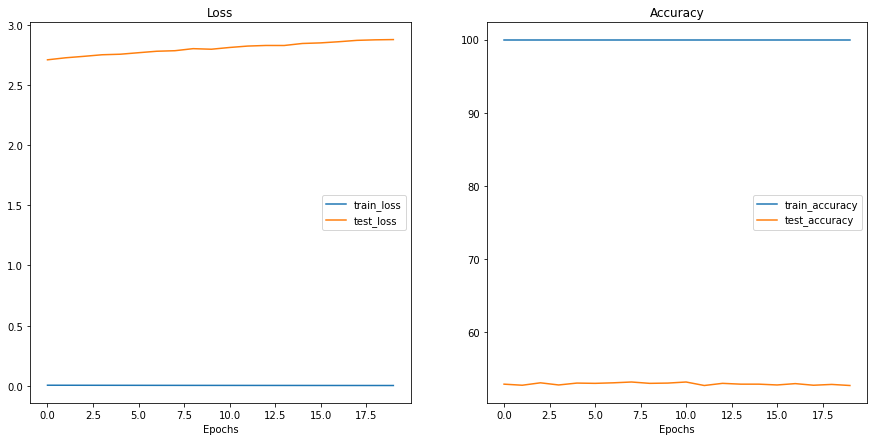

In [175]:
# Your graph
# Your graph
li={"train_loss": [],
      "test_loss": [],  
    }
for i in results["train_loss"]:
  li["train_loss"].append(i.cpu().detach())
 

for i in results["test_loss"]:
  li["test_loss"].append(i.cpu())


import numpy as np
plt.figure(figsize=(15, 7))

    # Plot loss
plt.subplot(1, 2, 1)
plt.plot(results["Epoch"],li["train_loss"], label='train_loss')
plt.plot(results["Epoch"], li["test_loss"], label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

    # Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(results["Epoch"], results["train_acc"], label='train_accuracy')
plt.plot(results["Epoch"], results["test_acc"], label='test_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

#### 2.3.1 Data augmentation

In [176]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
   # transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5)
])

val_transform = transforms.ToTensor()

train_set = imagefolder(train,transform)
test_val_set = imagefolder(test_val,transform)
#test_data = imagefolder(testing_set, val_transform)



### Data Augmentation


In [177]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_val_loader = torch.utils.data.DataLoader(
    test_val_set,
    batch_size=32, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    testing_set,
    batch_size=1, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

In [178]:
# Your code here!
# data augmentation


## Create a convolutional neural network 
class CNNModel(nn.Module):
   
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape,
                      128,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=2),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            #nn.Dropout(p=0.5),

            nn.Conv2d(128,
                      256,
                      kernel_size=3,
                      stride=1,
                      padding=2),
            nn.BatchNorm2d(256),         
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # default stride value is same as kernel_size
            #nn.Dropout(p=0.5) 

            nn.Conv2d(256,
                      512,
                      kernel_size=3,
                      stride=1,
                      padding=2),
            nn.BatchNorm2d(512),         
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5,
                         stride=2)   

            
            
                     

        )
       
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=32768, 
                      out_features=output_shape)
        )
    
    def forward(self, x):
       # x = self.block_1(x)
        # print(x.shape)
       # x = self.block_2(x)
        # print(x.shape)
       # x = self.classifier(x)
        # print(x.shape)
        return self.classifier(self.block_1(x))

torch.manual_seed(42)
model_3 = CNNModel(input_shape=3,
    output_shape=30).to(device)
model_3.to(device)

#loss func
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), 
                             lr=0.001)

#### 2.3.3 Hyperparameter tuning

> Use learning rates [0.1, 0.001, 0.0001]


In [187]:
# Your code here!
optimizer = torch.optim.SGD(params=model_3.parameters(), 
                             lr=0.001)

epochs = 50
for epoch in (range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model_3, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_val_loader,
        model=model_3,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

Epoch: 0
---------
Train loss: 1.89990 | Train accuracy: 44.44
Test loss: 1.99779 | Test accuracy: 42.54

Epoch: 1
---------
Train loss: 1.89639 | Train accuracy: 45.31
Test loss: 1.99277 | Test accuracy: 43.38

Epoch: 2
---------
Train loss: 1.89658 | Train accuracy: 44.75
Test loss: 1.99213 | Test accuracy: 42.12

Epoch: 3
---------
Train loss: 1.90387 | Train accuracy: 44.26
Test loss: 1.98401 | Test accuracy: 43.27

Epoch: 4
---------
Train loss: 1.88867 | Train accuracy: 44.63
Test loss: 1.99203 | Test accuracy: 41.08

Epoch: 5
---------
Train loss: 1.89339 | Train accuracy: 44.58
Test loss: 1.98710 | Test accuracy: 41.61

Epoch: 6
---------
Train loss: 1.88665 | Train accuracy: 44.71
Test loss: 1.98200 | Test accuracy: 43.01

Epoch: 7
---------
Train loss: 1.89021 | Train accuracy: 44.51
Test loss: 1.97760 | Test accuracy: 42.94

Epoch: 8
---------
Train loss: 1.87927 | Train accuracy: 44.59
Test loss: 1.99405 | Test accuracy: 42.27

Epoch: 9
---------
Train loss: 1.89370 | Train

In [188]:
import tqdm
results={"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "Epoch":[],
    }
    
epochs =20
    # 3. Loop through training and testing steps for a number of epochs
for epoch in range(epochs):
  train_loss, train_acc = train_step(model=model_3,
                                           data_loader=train_loader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn= accuracy_fn)
  test_loss, test_acc = test_step(model=model_3,
            data_loader=test_val_loader,
            loss_fn=loss_fn,
            accuracy_fn = accuracy_fn)
        
     
        # 5. Update results dictionary
  results["train_loss"].append(train_loss)
  results["train_acc"].append(train_acc)
  results["test_loss"].append(test_loss)
  results["test_acc"].append(test_acc)
  results["Epoch"].append(epoch)

Train loss: 1.88966 | Train accuracy: 44.96
Test loss: 1.97378 | Test accuracy: 42.68

Train loss: 1.87892 | Train accuracy: 45.46
Test loss: 1.99710 | Test accuracy: 41.68

Train loss: 1.87803 | Train accuracy: 45.21
Test loss: 1.96900 | Test accuracy: 43.35

Train loss: 1.88761 | Train accuracy: 44.86
Test loss: 1.97842 | Test accuracy: 43.12

Train loss: 1.88743 | Train accuracy: 44.95
Test loss: 1.97419 | Test accuracy: 43.01

Train loss: 1.87548 | Train accuracy: 45.32
Test loss: 1.99643 | Test accuracy: 42.34

Train loss: 1.87695 | Train accuracy: 45.42
Test loss: 1.96090 | Test accuracy: 43.87

Train loss: 1.88820 | Train accuracy: 45.13
Test loss: 2.00227 | Test accuracy: 41.89

Train loss: 1.89765 | Train accuracy: 44.51
Test loss: 1.98032 | Test accuracy: 42.97

Train loss: 1.88323 | Train accuracy: 44.58
Test loss: 1.97915 | Test accuracy: 42.87

Train loss: 1.88469 | Train accuracy: 44.60
Test loss: 1.98804 | Test accuracy: 42.13

Train loss: 1.87665 | Train accuracy: 45.32

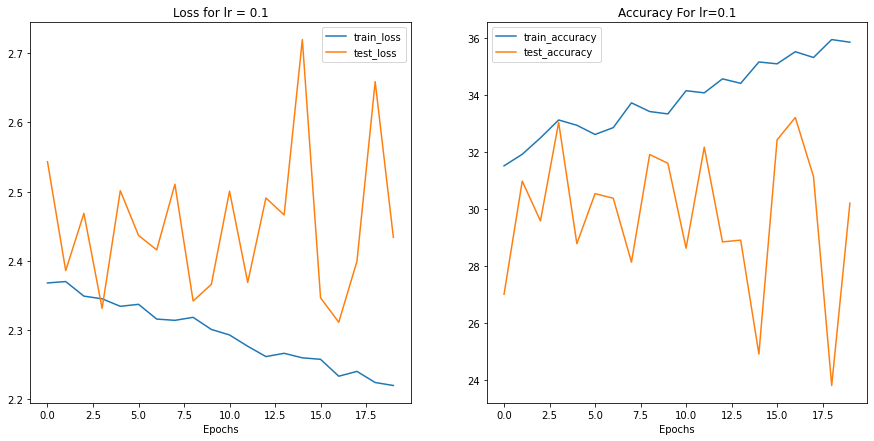

In [183]:
# Your graph
# Your graph
li={"train_loss": [],
      "test_loss": [],  
    }
for i in results["train_loss"]:
  li["train_loss"].append(i.cpu().detach())
 

for i in results["test_loss"]:
  li["test_loss"].append(i.cpu())


import numpy as np
plt.figure(figsize=(15, 7))

    # Plot loss
plt.subplot(1, 2, 1)
plt.plot(results["Epoch"],li["train_loss"], label='train_loss')
plt.plot(results["Epoch"], li["test_loss"], label='test_loss')
plt.title('Loss for lr = 0.01')
plt.xlabel('Epochs')
plt.legend()

    # Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(results["Epoch"], results["train_acc"], label='train_accuracy')
plt.plot(results["Epoch"], results["test_acc"], label='test_accuracy')
plt.title('Accuracy For lr=0.01')
plt.xlabel('Epochs')
plt.legend();

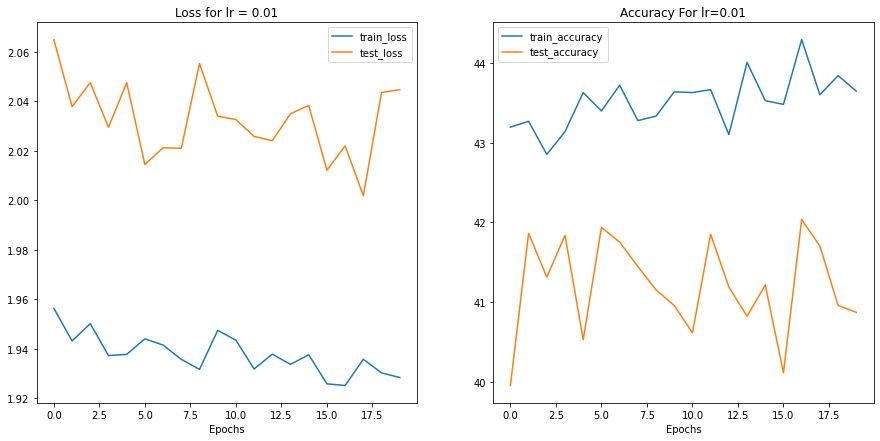

In [186]:
# Your graph
# Your graph
li={"train_loss": [],
      "test_loss": [],  
    }
for i in results["train_loss"]:
  li["train_loss"].append(i.cpu().detach())
 

for i in results["test_loss"]:
  li["test_loss"].append(i.cpu())


import numpy as np
plt.figure(figsize=(15, 7))

    # Plot loss
plt.subplot(1, 2, 1)
plt.plot(results["Epoch"],li["train_loss"], label='train_loss')
plt.plot(results["Epoch"], li["test_loss"], label='test_loss')
plt.title('Loss for lr = 0.01')
plt.xlabel('Epochs')
plt.legend()

    # Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(results["Epoch"], results["train_acc"], label='train_accuracy')
plt.plot(results["Epoch"], results["test_acc"], label='test_accuracy')
plt.title('Accuracy For lr=0.01')
plt.xlabel('Epochs')
plt.legend();

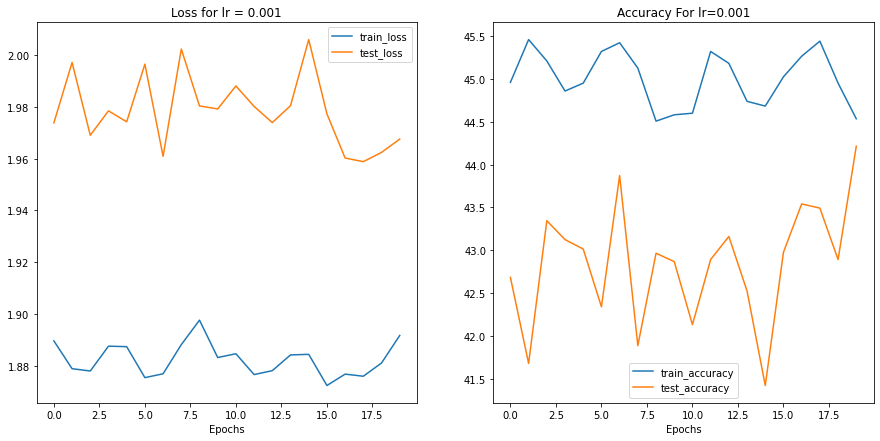

In [189]:
# Your graph
# Your graph
# Your graph
li={"train_loss": [],
      "test_loss": [],  
    }
for i in results["train_loss"]:
  li["train_loss"].append(i.cpu().detach())
 

for i in results["test_loss"]:
  li["test_loss"].append(i.cpu())


import numpy as np
plt.figure(figsize=(15, 7))

    # Plot loss
plt.subplot(1, 2, 1)
plt.plot(results["Epoch"],li["train_loss"], label='train_loss')
plt.plot(results["Epoch"], li["test_loss"], label='test_loss')
plt.title('Loss for lr = 0.001')
plt.xlabel('Epochs')
plt.legend()

    # Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(results["Epoch"], results["train_acc"], label='train_accuracy')
plt.plot(results["Epoch"], results["test_acc"], label='test_accuracy')
plt.title('Accuracy For lr=0.001')
plt.xlabel('Epochs')
plt.legend();

### 3 Model testing 


#### 3.1 Test class and predictions

In [23]:
# Your code here!
def predict_images(model, input_dir, output_file, batch_size=32, num_workers=2):
    # Set model to evaluation mode
    model.eval()
    model.cpu()
    

    # Define transformations for the input images
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        
    ])


    # Load the image files from the input directory
    file_names = os.listdir(input_dir)
    image_paths = [os.path.join(input_dir, file_name) for file_name in file_names]

    # Open a CSV file for output
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Id', 'Category'])

        # Iterate over the image paths and process them in batches
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]

            # Load the images in the batch and apply transformations
            batch_images = []
            for path in batch_paths:
                image = Image.open(path)
                image = transform(image)
                batch_images.append(image)
            batch_images = torch.stack(batch_images)

            # Pass the batch through the model for prediction
            with torch.no_grad():
                outputs = model(batch_images)

            # Get the predicted classes and write them to the CSV file
            _, predictions = torch.max(outputs, dim=1)
            for j, prediction in enumerate(predictions):
                writer.writerow([file_names[i+j], prediction.item()])


In [ ]:
# Your code here! 
predict_images(model_3,testing_set,'/content/drive/MyDrive/sc22msb.csv' )


### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset

In [ ]:


#without freezing layers

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary



transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227,227))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227,227))
])

# Load CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Define dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


alexnet = torchvision.models.alexnet(pretrained=True)


alexnet.classifier[6] = nn.Linear(4096, 10)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

# Train the model
alexnet.cuda()
for epoch in range(10):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

# Test the model
alexnet.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


#### 4.2 Fine-tuning model with frozen layers

> Configuration 2: Frozen base convolution blocks

In [ ]:

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227,227))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227,227))
])

# Load CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Load pre-trained AlexNet model
alexnet = torchvision.models.alexnet(pretrained=True)


for param in alexnet.parameters():
    param.requires_grad = False
alexnet.classifier[6] = nn.Linear(4096, 512)
alexnet.classifier.add_module('7', nn.ReLU(inplace=True))
alexnet.classifier.add_module('8', nn.Dropout())
alexnet.classifier.add_module('9', nn.Linear(512, 10))
alexnet.classifier.add_module('10', nn.LogSoftmax(dim=1))

# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, alexnet.parameters()), lr=0.001, momentum=0.9)

# Train the model
alexnet.cuda()
for epoch in range(100):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

# Test the model
alexnet.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the 10000 test images: %d %%' % (100 * correct / total))


#### 5.1 Finetune AlexNet on TinyImageNet30
> Load AlexNet as you did above

> Train AlexNet on TinyImageNet30 dataset until convergence. Make sure you use the same dataset

In [ ]:
# Your code here! 
# Test the mode


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define transforms for data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227,227))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227,227))
])



# Define dataloaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_val_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Load pre-trained AlexNet model
alexnet = torchvision.models.alexnet(pretrained=True)

# Freeze all layers except for the last two fully connected layers
for param in alexnet.parameters():
    param.requires_grad = False
alexnet.classifier[6] = nn.Linear(4096, 512)
alexnet.classifier.add_module('7', nn.ReLU(inplace=True))
alexnet.classifier.add_module('8', nn.Dropout())
alexnet.classifier.add_module('9', nn.Linear(512, 10))
alexnet.classifier.add_module('10', nn.LogSoftmax(dim=1))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, alexnet.parameters()), lr=0.001, momentum=0.9)

# Train the model
alexnet.cuda()
for epoch in range(50):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

# Test the model
alexnet.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_val_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
